# Kinetic MWC Model without Explicit Ligand Dynamics
### Maxim Zewe at AMOLF in Fall 2023

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit

In [2]:
# define some colours to use throughout for plotting
my_red = '#CD5C5C'
my_blue = '#5D8AA8'
my_yellow = '#ED9121'
my_green = '#708238'

In [3]:
# set the events with the corresponding rates
@numba.jit(nopython=True)
def propensities(state,c,methylation,activation,N,
                delta_f=-2,Ki=18,Ka=2900,kR=0.075,kB=0.15,kAct=50):
    # arrays to store results
    rates = np.zeros(2)
    events = np.zeros((2,2))

    # calculate free-energy difference
    mbase = N/2
    f = N*np.log((1 + c/Ki)/(1 + c/Ka)) + delta_f*(state[1] - mbase)

    # set rate constants for (de)activation
    kDeact = kAct*np.exp(f)

    # check methylation states
    mMax = 4*N
    meth_ceiling = state[1] < mMax
    meth_floor = state[1] > 0

    # for inactive cluster
    if state[0] == 0:
        # methylation; only possible if a site is available
        rates[0] = kR*meth_ceiling*methylation
        events[0] = [0,1]

        # activity switching
        rates[1] = kAct*activation
        events[1] = [1,0]

    # for active cluster
    else:
        # demethylation; only possible if a site is occupied
        rates[0] = kB*meth_floor*methylation
        events[0] = [0,-1]

        # deactivation
        rates[1] = kDeact*activation
        events[1] = [-1,0]
        
    return rates, events

# function to draw a biased sample in numba
@numba.jit(nopython=True)
def biased_choice(outcomes,prob):
    return outcomes[np.searchsorted(np.cumsum(prob), np.random.rand(1))]

# function to implement Gillespie's direct algorithm
@numba.jit(nopython=True)
def gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,
                    Nr=6,methylation=True,activation=True,cbase=100):
    # set up arrays to hold the results
    t_grid = np.linspace(0,tf,n_steps+1)
    all_states = np.zeros((n_sims,n_steps+1,2))

    ############# actual algorithm #############
    
    for i in range(n_sims):
        # initialise each realisation
        a0 = biased_choice(np.array([0.,1.]),np.array([2/3,1/3]))[0]
        state = np.array([a0, m0])
        all_states[i,0,0] = a0
        all_states[i,0,1] = m0
        dt = 0
        time = 0
        
        # loop over all time steps
        for j in range(n_steps):
            # change concentration after step_change time steps
            if j >= step_change:
                c = cnew
            else:
                c = cbase
                
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # set state to extract rates and propensities
                rates, events = propensities(state,c,methylation,activation,Nr)

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                mask = p < np.cumsum(rates)
                event_idx = np.where(mask == True)[0][0]

                # this samples the time until the next event
                u = np.random.uniform(0,1)
                dt = -np.log(u)/np.sum(rates)
                time += dt
                
            # keep updating until we reach the end of the interval
            while time < t_grid[j]:                
                # extract rates and propensities for next round
                state = state + events[event_idx]
                rates, events = propensities(state,c,methylation,activation,Nr)

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                mask = p < np.cumsum(rates)
                event_idx = np.where(mask == True)[0][0]

                # this samples the time until the next event
                u = np.random.uniform(0,1)
                dt = -np.log(u)/np.sum(rates)
                time += dt
                
            # save the last state before passing the boundary
            all_states[i,j+1,:] = state
            
    ############ averaging ############
    
    av_states = np.zeros((n_steps+1,2))
    
    # averaging in the awkward numba way
    for j in range(n_steps+1):
        for k in range(2):
            av_states[j,k] = np.mean(all_states[:,j,k])
            
    # normalise
    mMax = 4*Nr
    av_states[:,1] = av_states[:,1]/mMax
            
    return all_states, av_states, t_grid

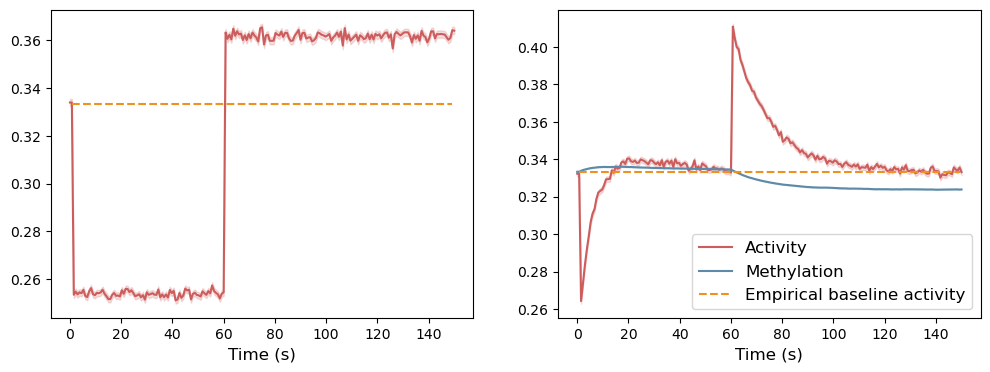

In [7]:
# check that the algorithm works
m0 = 8.
tf = 150
n_steps = 200
n_sims = 10**5
step_change = 80
cnew = 90

# prepare figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

####################
## No methylation ##
####################

# extract results and standard deviations
all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=False)
sem = np.std(all_states[:,:,0],axis=0)/np.sqrt(n_sims)

ax1.plot(time,results[:,0],color=my_red,label='Activity')
ax1.fill_between(time,results[:,0]-sem,results[:,0]+sem,color=my_red,alpha=0.2)
ax1.axhline(y=1/3,xmin=0.05,xmax=0.95,linestyle='--',color=my_yellow,label='Empirical baseline activity')
ax1.set_xlabel('Time (s)',size=12)

######################
## With methylation ##
######################

# extract results and standard deviations
all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=True)
sem_act = np.std(all_states[:,:,0],axis=0)/np.sqrt(n_sims)
sem_meth = np.std(all_states[:,:,1]/24,axis=0)/np.sqrt(n_sims)

ax2.plot(time,results[:,0],color=my_red,label='Activity')
ax2.fill_between(time,results[:,0]-sem_act,results[:,0]+sem_act,color=my_red,alpha=0.2)
ax2.plot(time,results[:,1],color=my_blue,label='Methylation')
ax2.fill_between(time,results[:,1]-sem_meth,results[:,1]+sem_meth,color=my_blue,alpha=0.2)
ax2.axhline(y=1/3,xmin=0.05,xmax=0.95,linestyle='--',color=my_yellow,label='Empirical baseline activity')
ax2.set_xlabel('Time (s)',size=12)
ax2.legend(fontsize=12,loc='lower right')

plt.show()

In [8]:
# check how fast the algorithm is
m0 = 8.
tf = 100
n_steps = 160
n_sims = 10**2
step_change = 80
cnew = 90

%timeit gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=False)

306 ms ± 7.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Running the algortihm $10^4$ under these conditions would take about 30 s.  

## Dose-response curve

In this section, we use the simulation to extract the dose-response curve. The procedure is as follows. We turn methylation off to prevent adaptation. After equilibration, the cluster receives a step increase in concentration, upon which the activity settles to a new equilibrium. We measure the amplitude of the response as the difference between the activity just before the change in concentration and the new equilibrium activity, which we take from the last point of the simulation. Repeating this procedure for various values of the final concentration allows us to extract a dose-response curve. 

The aim here is not to replicate any measured dose-response curve. Instead, the aim is to reproduce some qualitative characteristics of a typical dose-response curve extracted from an MWC model, such as its sigmoidal shape. This would provide evidence that our model agrees with the non-dynamical MWC model.

In [9]:
@numba.jit(nopython=True)

def drc(cnew_arr,
        m0=3+3*np.log((1+100/18)/(1+100/2900)),tf=100,n_steps=200,step_change=100,n_sims=10**3):
    # array to store results
    all_responses = np.zeros((cnew_arr.size,n_sims),dtype='float32')
    
    # loop through various final concentrations
    for i,cnew in enumerate(cnew_arr):
        # obtain activity
        all_states,_,_ = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=False)
        
        # loop through all realisations
        for sample in range(n_sims):
            # pre-stimulus activity
            a_pre = np.mean(all_states[sample,step_change-51:step_change-1,0])
            
            # post-stimulus activity
            a_post = np.mean(all_states[sample,-50:,0])
            
            # save the responses
            all_responses[i,sample] = a_post-a_pre
            
    return all_responses

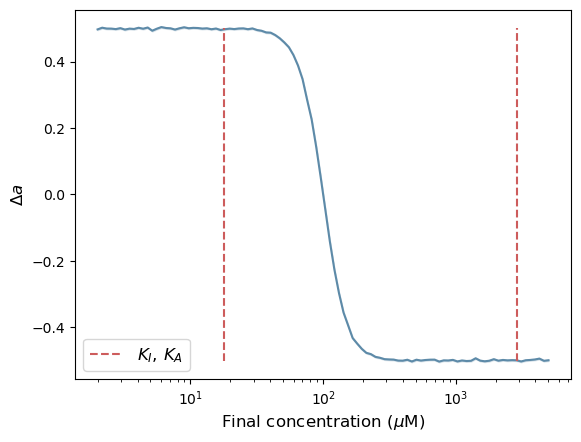

In [10]:
# find responses
cnew_arr = np.logspace(0.3,3.7,100)
responses = drc(cnew_arr)

# extract means and error bars
mean_responses = np.mean(responses,axis=1)
sd_responses = np.std(responses,axis=1)

# plot the results
plt.semilogx(cnew_arr,np.mean(responses,axis=1),ls='-',color=my_blue)
plt.fill_between(cnew_arr,mean_responses-sd_responses,mean_responses+sd_responses,color=my_blue,alpha=0.2)
plt.axvline(x=18,ymin=0.05,ymax=0.95,ls='--',color=my_red)
plt.axvline(x=2900,ymin=0.05,ymax=0.95,ls='--',color=my_red,label=r'$K_I,\, K_A$')
plt.xlabel(r'Final concentration ($\mu$M)',size=12)
plt.ylabel(r'$\Delta a$',size=12)
plt.legend(fontsize=12)
plt.show()

## Fitting to Extract Response and Adaptation Timescale

This part uses a model proposed by Mattingly et al. (2021) for the shape of the response curve as

$$ K(t) = G \exp\{-t/\tau_2\}(1 - \exp\{-t/\tau_1\})H(t), $$

where $K(t)$ is the response, $G$ is the gain or amplitude, $\tau_1$ is the rise time, $\tau_2$ is the adaptation time and $H(t)$ is the Heaviside step function. Note that we have subtracted the baseline activity and set $t=0$ when the concentration is increased. Furthermore, Mattingly et al. only probed responses for a 10% increase or decrease in concentration, starting from a background of 100 $\mu$M.

Additionally, this model is fitted to a rescaled version of the activity. Concretely, $K(t)$ is fitted to $a(t)/\log(c_0/c_f)$, where $c_f = 90 \, \mu$M is the final concentration and $c_0 = 100\,\mu$M is the baseline concentration.   

Ultimately, the aim of this section is to compare our fitting results to those of Mattingly et al. They find $G = 1.73 \pm 0.03$, $\tau_1 = 0.22 \pm 0.01$ s and $\tau_2 = 9.90 \pm 0.30$ s, so we would like to verify to what extent our simulations reproduce these features of their experiment.

In [11]:
# define model function
def mattingly_fit(t,G,tau1,tau2):
    return G*(1 - np.exp(-t/tau1))*np.exp(-t/tau2)

# function for extracting the response
def response_kernel(all_states,step_change,time,cnew=90,plot_bool=False):
    # extract mean
    activity = np.mean(all_states[:,:,0],axis=0)
    
    # find response and shift time
    baseline = np.mean(activity[step_change-1000:step_change])
    response = (activity[step_change-1:] - baseline)/np.log(100/cnew)
    shifted_time = time[step_change-1:] - time[step_change-1]
    
    # extract standard deviations of response
    sd_resp = np.std(all_states[:,step_change-1:,0],axis=0)/np.log(100/cnew)
    
    # perform fitting
    popt, pcov = curve_fit(mattingly_fit,shifted_time,response,p0=[0.7,0.1,10],sigma=sd_resp)
    
    # show plot if desired
    if plot_bool:
        plt.plot(shifted_time,response,'.',label='Simulation',color=my_red,alpha=0.05)
        plt.plot(shifted_time, mattingly_fit(shifted_time, *popt_lit),label='Fit',color=my_red)
        plt.xlabel('Time (s)')
        plt.ylabel('Response')
        plt.title(r'Fitting procedure for linear response function ($N=6, \; N_c = 400$)')
        plt.show()
        
    # return the fitting parameters and their uncertainties
    return response, shifted_time, popt, [np.sqrt(pcov[i,i]) for i in range(3)]

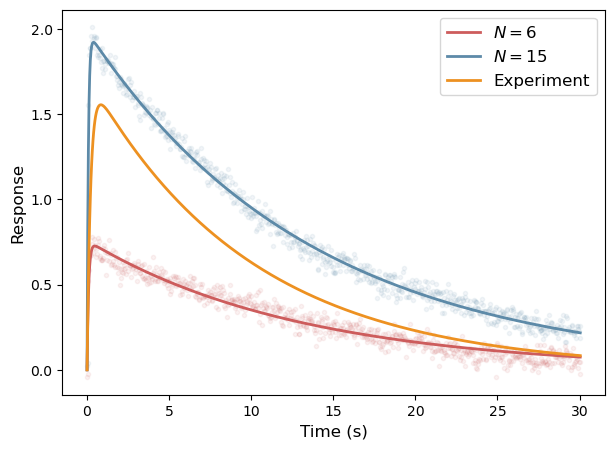

Literature values: [G, taur, taua] =  [ 0.75835054  0.09498354 12.98602765]  with sd =  [0.005505551538068536, 0.007623524285534176, 0.1389478647504517]
Adjusted values: [G, taur, taua] =  [ 1.9881399   0.07601989 13.56236644]  with sd =  [0.006499747610068398, 0.003114388970868446, 0.06640719573220136]


In [206]:
# obtain nice data
m0 = 8.
tf = 400
n_steps = 10**4
n_sims = 10**4
step_change = 9250
cnew = 90

# obtain data for literature values 
all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew)
response_lit, shifted_time, popt_lit, sds_lit = response_kernel(all_states,step_change,time)

# obtain data for adjusted values
all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,Nr=15)
response_adj, shifted_time, popt_adj, sds_adj = response_kernel(all_states,step_change,time)

# figure showing the different response kernels
fig = plt.figure(figsize=(7,5))

# literature values
plt.plot(shifted_time,mattingly_fit(shifted_time,*popt_lit),label=r'$N = 6$',color=my_red,linewidth=2.0)
plt.plot(shifted_time,response_lit,'.',color=my_red,alpha=0.08)

# adjusted values
plt.plot(shifted_time,mattingly_fit(shifted_time,*popt_adj),label=r'$N = 15$',color=my_blue,linewidth=2.0)
plt.plot(shifted_time,response_adj,'.',color=my_blue,alpha=0.08)

# experiment and formatting
plt.plot(shifted_time,mattingly_fit(shifted_time,1.73,0.22,9.90),label='Experiment',color=my_yellow,linewidth=2.0)
plt.xlabel('Time (s)',size=12)
plt.ylabel('Response',size=12)
plt.legend(fontsize=12)
plt.show()

# report fitting results
print('Literature values: [G, taur, taua] = ', popt_lit,' with sd = ', sds_lit)
print('Adjusted values: [G, taur, taua] = ', popt_adj,' with sd = ', sds_adj)

### Interpretation

Our fit indicates time scales $\tau_1$ and $\tau_2$ for response and adaptation, respectively, similar to those found by Mattingly and colleagues. However, our estimate of $G$ is an order of magnitude lower than their experiments suggest. This aligns with Manuel's findings. Together, this indicates that our dynamical MWC does not reproduce the experiments by Mattingly et al. well, given the parameter values that are often used in the literature. Therefore, we assess whether changing the number of receptors per cluster ($N$) and number of clusters ($N_c$) removes the discrepancy between our simulations and their experiments. Concretely, we follow Manuel's suggestion to change $N$ from 6 to 15 and $N_c$ from 400 to 9. Note that while $N_c$ does not affect the procedure for finding $K(t)$, it does have a strong effect on the noise kernel (see below).

The fitted values for $N=15$ and $N_c = 9$ are in much better agreement with the experimental results by Mattingly et al., with $G$ in particular. For convenience, we show both the simulated fits as well as the fit obtained by Mattingly et al. in the plot below.

## Noise kernel

Here we estimate the noise kernel in order to compare our results to Mattingly et al.'s work. The aim is to find the autocorrelator, which we do as follows. Firstly, we simulate a trajectory $a_i(t)$ on the cell level, meaning that it is averaged over $N_c = 400$ clusters. Since we are interested in the steady-state noise, the background concentration is kept constant at $c = 100\,\mu$M and the transient until reaching equilibrium is cut off. We repeat this procedure $N_s$ times to obtain the activities $a_1(t),...,a_{N_s}(t)$. The noise kernel is then defined as the autocorrelation of the activity with itself,

$$ N(t) \equiv \langle a(t)a(0) \rangle - \langle a(t) \rangle \langle a(0) \rangle, $$

with $t=0$ where the transient is cut off. Computing $N(t)$ thus requires taking ensemble averages over the sets $\{ a_1(t), ..., a_{N_s}(t)\}$, $\{a_1(0),...,a_{N_s}(0) \}$ and $\{a_1(t)a_1(0),...,a_{N_s}(t)a_{N_s}(0) \}$.

Measurements indicate that $x(t)$ is well approximated by an Ornstein-Uhlenbeck process, such that the noise kernel is of the form

$$ N(t) = \sigma_n^2 \exp\{-|t|/\tau_n\}, $$

where $\sigma_n$ sets the amplitude and $\tau_n$ the time scale of the fluctuations in $x(t)$. From their measurements, Mattingly et al. find that $\sigma_n = 0.092 \pm 0.002$ and $\tau_n = 11.75 \pm 0.04$ s, so the aim of this section is to check whether our simulations agree with these values.

In [22]:
@numba.jit(nopython=True)

# function for finding several realisations of single-cell activity
def activity_finder(n_steps,tf,n_samples,N,Nc,m0=8.,meth_bool=True):
    # array to save results
    all_act = np.zeros((n_steps+1,n_samples))
    step_change = n_steps + 1
    
    for sample in range(n_samples):
        # obtain a realisation
        all_states, results, time = gillespie_nolig(m0,tf,n_steps,Nc,step_change,100,Nr=N,methylation=meth_bool)
        
        # store only the activity
        all_act[:,sample] = results[:,0]
        
    return all_act, time

# function for finding autocorrelator of a time series; not in Numba mode!
def autocorr(all_act,time,co):
    # obtain average of product
    ata0_av = np.mean(all_act[co:,:]*all_act[co,:],axis=1)
    
    # obtain factors for product of averages
    at_av = np.mean(all_act[co:,:],axis=1)
    a0_av = np.mean(all_act[co,:])
    
    # shift time
    time_s = time[co:] - time[co]
    
    # return the autocorrelator: average of product minus product of averages
    return ata0_av-at_av*a0_av, time_s

In [ ]:
# set parameters for long-term noise kernel
n_steps = 2000
tf = 100
n_samples = 10**3
co = 1200

# define model function
def noise_fit(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

# prepare figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

# find noise kernel for literature and adjusted values
for i in range(2):
    if i == 0:
        # literature case
        label = r'$N_c=400$'
        N = 6
        Nc = 400
        color = my_red
    else:
        # adjusted values
        label = r'$N_c=9$'
        N = 6 ############################### check this
        Nc = 9
        color = my_blue

    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc)

    # compute autocorrelator
    auto_corr, time_s = autocorr(all_act,time,co)

    # ignore the first point
    auto_corr_nofirst = auto_corr[1:]
    time_s_nofirst = time_s[1:] - time_s[1]

    # perform fitting
    popt_n, pcov_n = curve_fit(noise_fit,time_s_nofirst,auto_corr_nofirst)

    print('Parameters of best fit: [sigma, tau_n] =', popt_n)
    print('Standard deviations:', [np.sqrt(pcov_n[i,i]) for i in range(2)])

    # show results, including the zero-lag time point
    ax1.plot(time_s_nofirst,auto_corr_nofirst,'.',color=color,alpha=0.2)
    ax1.plot(time_s_nofirst,noise_fit(time_s_nofirst,*popt_n),label=label,color=color,linewidth=2.0)
    
ax1.plot(time_s_nofirst,noise_fit(time_s_nofirst,0.092,11.75),label='Experiment',color=my_yellow,linewidth=2.0)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel('Noise kernel',size=12)
ax1.legend(fontsize=12)

# reset parameters for short-term noise kernel
n_steps = 25000
tf = 20
co = 24950

# find noise kernel for literature and adjusted values
for i in range(2):
    if i == 0:
        # literature case
        label = r'$N_c=400$'
        N = 6
        Nc = 400
        color = my_red
    else:
        # adjusted values
        label = r'$N_c=9$'
        N = 6 ############################### check this
        Nc = 9
        color = my_blue

    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc)

    # compute autocorrelator
    auto_corr, time_s = autocorr(all_act,time,co)

    # show results
    ax2.plot(time_s,auto_corr,'.',color=color,alpha=1)
    
ax2.set_xlabel('Time (s)',size=12)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

### Interpretation

From our fitting procedure, we consistently find values of $\sigma_n$ that are roughly a factor of 10 below Mattingly et al.'s estimate. This agrees with Manuel's findings. Evidently, the dynamic MWC model does not reproduce the data by Mattingly et al. well given the parameters frequently used in the literature. Therefore, we check whether the agreement between simulations and experiment is better if we change the parameter values as suggested by Manuel, so we take $N=15$ and $N_c = 9$ instead of $N=6$ and $N_c=400$. 

Indeed, this makes our simulation and Mattingly's data agree very well. Also note that on very short time scales, the noise kernel behaves differently then expected for a simple Ornstein-Uhlenbeck process. In particular, the initial point is much higher than expected and there seems to be a fast decay before the slow regime takes over. We speculate that the slow decay time is set by the methylation time, whereas the fast regime stems from noise in the activity, which is on the time scale of 10-100 ms, in line with what we observe.

### Noise kernel without methylation

We are interested in estimating the time scale of the autocorrelator decay without adaptation. The reason is that this will be useful for parameter estimation in the Ising model. Since the goal is parameter estimation, the parameters in this simulation are chosen such that they reproduce the experimental results as closely as possible.

Parameters of best fit: [sigma, tau_N] = [0.14389613 0.00527665]
Standard deviations: [0.0003457961649824586, 3.861635023254055e-05]


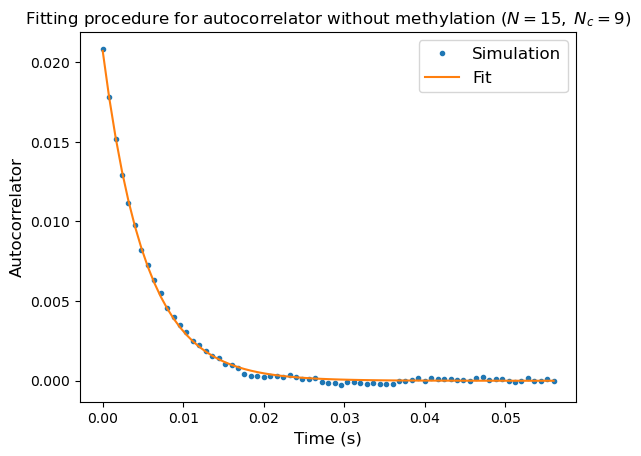

In [23]:
# set parameters
n_steps = 25000
tf = 20
n_samples = 10**4

# receptor parameters
N = 15
Nc = 9

# obtain activities
all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc,meth_bool=False)

# set cut-off
co = 24930

# compute autocorrelator
auto_corr, time_s = autocorr(all_act,time,co)

# define model function
def noise_fit(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

# perform fitting
popt_nometh, pcov_nometh = curve_fit(noise_fit,time_s,auto_corr)

print('Parameters of best fit: [sigma, tau_N] =', popt_nometh)
print('Standard deviations:', [np.sqrt(pcov_nometh[i,i]) for i in range(2)])

# show results
plt.plot(time_s,auto_corr,'.',color=my_green,label='Simulation',alpha=0.4)
plt.plot(time_s,noise_fit(time_s,*popt_nometh),label='Fit',color=my_green,linewidth=2.0)
plt.xlabel('Time (s)',size=12)
plt.ylabel('Autocorrelator',size=12)
plt.title(r'Fitting procedure for autocorrelator without methylation ($N=15, \; N_c = 9$)')
plt.legend(fontsize=12)
plt.show()